In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn import model_selection
from collections import Counter

from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error


seed = 42

# Funciones Auxiliares

In [2]:
def read_data():
    
    directorio = 'datos/'
    file       = 'YearPredictionMSD.txt'

    path       = directorio + file

    # Leemos los dos ficheros y lo metemos en un dataframe de pandas

    df  = pd.read_table(path,delimiter=",",header=None,na_values = 'NA')

    # Obtenemos el nombre de las características
    features = df.columns.to_list()

    # Cambiamos las etiquetas a valores numericos
    return df, features


def remove_outliers(dftrain, show=True, index_label = 0):
    """
    Elimina los outliers del Data Frame pasado como argumento inplace.
    La eliminación de los outliers se hará solo en la clase mayoritaria, debido al desbalanceo
    
    Params:
    ----------
        - dftrain: pd.DataFrame: Matriz con los datos
            - Constraint:
                Debe contener en una columna las etiquetas
        - outliers_ft: list/np.ndarray
            Lista con los atributos que tienen valores perdidos
            
    Return:
    ----------
        - indices con las filas con outlies
        - indices cuyas instancias con outliers tienen la clase positiva y negativa respecivamente
    """
    # Diccionario con outliers
    outliers = {}

    if show:
        print("outliers=-1")
        print("no outliers = 1")
    
    # Para cada atributo con outliers
    for col in dftrain.columns:
        if col != index_label:
            # Declaramos una instancia de LOF
            clf = LocalOutlierFactor(n_neighbors=20)
            # Obtenemos el array con los outliers (1: no es outliers, -1: si)
            arr = clf.fit_predict(dftrain[col].to_numpy().reshape(-1,1))
            outliers[col] = arr
            if show:
                # Visualizamos la contidad de outliers

                print(f"========== Outliers: {col} ==========")
                print(Counter(arr))
            
            
    # Creamos un diccionario:  clave-columnas y el valor-indices de los outliers
    outliers_indexs = {}

    for ft, arr in outliers.items(): # Buscamos los indices de los outliers que son aquellos que tienen 1 en el vector
        outliers_indexs[ft] = np.where(outliers[ft]==-1)[0] # Porque es una tupla y queremos la primera posicion
        
        
    # Indices en los que aparece un outliers (no hay repetidos)
    index     = []

    # Iteramos en el diccionario
    for ft, vector in outliers_indexs.items():
        # Iteramos sobre los elemetnos del vector
        for el in vector:
            # Si el elemento no esta en el conjunto de indices
            if el not in index:
                # Lo metemos
                index.append(el)


    # Convertimos los arryaus en np.ndarray
    index = np.asarray(index)

    if show:
        print("Index.shape = ",index.shape) 
        print("========== Antes ==========")
        print("Tamanio", dftrain.shape)

    # Ordenamos indices de mayor a menor para ir eliminando sin que se vean modificados
    # los indices anteriores y así evitar eliminar algo que no debe ser borrado
    index = np.sort(index)[::-1]
    # Eliminción de outliers en el conjunto de la etiqueta mayoritaria
    for idx in index:
        dftrain.drop(dftrain.index[[idx]],axis=0,inplace=True)

    if show:
        print("========== Despues ==========")
        print("Tamanio", dftrain.shape)

    return index

def desnormalizar(dftrain,dftest=None,features = None, mean = None, std = None, training_only = False):
    """
    Esta función se aplica a los datos de entrenamiento y test que previamente se han normalizado
    para restaurar sus valores originales
    
    Params:
    ----------
        - mean: media que se ha usdo para normalizra
        - std: desviación tipica usada para normalizar
        
    Return:
    ----------
        No devuelve nada, las modificaciones se hacen in-place
    """
    
    for i, col in enumerate(features):
        
        dftrain[col] = dftrain[col]*std[i] + mean[i]
        if training_only == False:
            dftest[col]  = dftest[col]*std[i] + mean[i]

def normalizar_zscore(df_train,df_test = None,features = None, training_only = False):
    """
    Normalizar df_train a con media 0 y varianza 1 y usa los mismos datos
    para normalizar el conjunto de test.
    
    Return:
    ---------
        - Vector con la media de cada columna
        - Vector con la desviación típica de cada columna
        Modifica los argumentos in place
    """
    vmean = []
    vstd  = []

    for col in features:
        mean = df_train[col].mean()
        std  = df_train[col].std(ddof=0)
        
        vmean.append(mean)
        vstd.append(std)
        
        df_train[col] = (df_train[col] - mean) / std
        if training_only == False:
            df_test[col]  = (df_test[col] - mean) / std

    return vmean, vstd


def plot2D(x,y,title):
    """ Función para visualizar una muesta etiquetada en 2D

        Args: 
            x: muestra de puntos a visualizar
            y: vector de etiquetas asociado a la muestra x
            title: título para el gráfico generado 
        """

    plt.figure(figsize=(10,10))
    plt.scatter(x[:,0],x[:,1],c=y, cmap='tab20', alpha=0.5)
    plt.colorbar()
    plt.title(title)
    plt.show()

def plot3D(x,y,title,figsize=(10,10),view=[45,45]):
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2],c=y,cmap='tab20',alpha=0.5)  
    ax.set_xlabel('Primera Componente')
    ax.set_ylabel('Segunda Componente')
    ax.set_zlabel('Tercera Componente')
    ax.set_title(title)
    ax.view_init(view[0],view[1])
    plt.show()
    
def pandas_to_numpy(df):
    y = df[0].to_numpy().reshape(-1,1)
    df.drop(0,axis=1,inplace=True)
    X = df.to_numpy()
    return X, y
    
    
def preprocesado(dftrain,dftest = None,corr=[18,23,22], training_only = False):
    # Normalizamos para quitar outliers y desnormalizamos
    vmean, vstd = normalizar_zscore(dftrain,dftest,dftrain.columns, training_only)
    remove_outliers(dftrain,show=False,index_label=0)
    desnormalizar(dftrain,dftest,dftrain.columns, vmean, vstd,training_only)
    # Volvemos a normaliar con las caracteristicas del conjunto de datos sin outliers
    vmean, vstd = normalizar_zscore(dftrain,dftest,dftrain.columns, training_only)
    
    # Eliminamos atributos con correlaciones
    corr = [18,22,23]
    for col in corr:
        dftrain.drop(col,axis=1,inplace=True)
        if training_only == False:
            dftest.drop(col,axis=1, inplace=True)
        
    # Obtenemos conjuntos de etiquetas y datos por separado en formato numpy
    y_train = dftrain[0].to_numpy().reshape(-1,1)
    dftrain.drop(0,axis=1,inplace=True)
    X_train = dftrain.to_numpy()
        
    if training_only:
        return X_train, y_train
    else:
        y_test  = dftest[0].to_numpy().reshape(-1,1)
        dftest.drop(0,axis=1,inplace=True)
        X_test  = dftest.to_numpy()
        return X_train, y_train, X_test, y_test


def dimensionality_reduction(n_components, X_train,X_test,show=False, training_only = False):
    """
    Función que reduce la dimensionalidad del conjunto de datos aplicando pca
    """
    pca = PCA(n_components = n_components,random_state = seed)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)

    if show:
        print("Varianza explicada: ", pca.explained_variance_ratio_.sum())
        print("Componentes: ", len(pca.components_))

    if training_only:
        return X_train_pca, pca
    else:
        X_test_pca  = pca.transform(X_test)
        return X_train_pca, X_test_pca, pca

def apply_grid(estimator,parameters,X,y,mensaje = None ,show=True):
    
    grid = GridSearchCV(estimator,parameters, n_jobs=-1,scoring='neg_mean_squared_error')
    grid.fit(X,y)
    pol = pd.DataFrame(grid.cv_results_)
    
    if show:
        if mensaje != None:
            print(mensaje)
        print("Best Score: ", -grid.best_score_)
        print("Best Params: ", grid.best_params_)
    
    return pol



def get_final_results(modelo,X_train,y_train,X_test,y_test,name_modelo=None,show=False):
    """
    Función que entrena un modelo con los datos de entrenamiento y los evalua usando los datos de test.
    
    Return:
    ----------
        - f1_train: float
        - f1_test: float
    """
    
    #Entrenamos el modelo
    modelo.fit(X_train,y_train)
    
    #Predecimos en entrenamiento y test
    y_pred_test  = modelo.predict(X_test)
    y_pred_train = modelo.predict(X_train)
    # Calculamos metrica
    mse_train = mean_squared_error(y_train,y_pred_train)
    mse_test = mean_squared_error(y_test,y_pred_test)
    # La mostramos
    if show:
        if name_modelo != None:
            print(name_modelo)
        print("MSE en el conjunto de entranamiento: ", mse_train)
        print("MSE en el conjunto de test: ",mse_test)
    
    return mse_train, mse_test


def plot_learning_curve(X,y,percentage,modelo,metrica,modelo_str,metrica_str,stratify = True, figsize = (10,10)):
    # Divimos en entrenamiento y validacon 
    if stratify:
        X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, train_size= 0.8, random_state=seed, stratify = y, shuffle=True)
    else:
        X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, train_size= 0.8, random_state=seed, shuffle=True)
    # Numero de ejemplos a entrenar en total
    n_samples = X_train.shape[0]
    # Tamaño de ventana
    window = int(n_samples * percentage)
    # En donde vamos a guardar los datos de los ejes
    ejeX       = []
    ejeY_train = []
    ejeY_val   = []
    
    str1 = 'Training'
    str2 = 'Val'
    
    for i in range(int(percentage*100) + 1):
        # Entrenamos el modelo 
        modelo.fit(X_train[:window*(i+1)], y_train[:window*(i+1)])
        # Predecimos
        ypred_train = modelo.predict(X_train[:window*(i+1)])
        ypred_val   = modelo.predict(X_val)
        # Guardamos resultados
        ejeY_train.append( metrica( y_train[:window*(i+1)], ypred_train)  )
        ejeY_val  .append( metrica( y_val                 , ypred_val  )  )
        ejeX      .append( window*(i+1))
                        
        
    plt.figure(figsize = figsize)
    plt.plot(ejeX,ejeY_val,label=str2)
    plt.plot(ejeX,ejeY_train,label=str1)
    
    
    

    plt.ylabel(metrica_str)
    plt.xlabel('Training Size')
    plt.legend()
    plt.title('Learning Curve')

# Lectura de datos

In [3]:
df,features = read_data()
dftrain, dftest = train_test_split(df.copy(), test_size = 0.2, train_size= 0.8, random_state=seed, shuffle=True)

# Preprocesado: 
No hace falta ejecutar estas celdas, las he resumido en una única función que se llamará cuando sea necesario

Quitamos outliers y normalizamos

In [4]:
# Normalizamos para quitar outliers y desnormalizamos
vmean, vstd = normalizar_zscore(dftrain,dftest,dftrain.columns)
remove_outliers(dftrain,show=False,index_label=0)
desnormalizar(dftrain,dftest,dftrain.columns, vmean, vstd)
# Volvemos a normaliar con las caracteristicas del conjunto de datos sin outliers
vmean, vstd = normalizar_zscore(dftrain,dftest,dftrain.columns)

Vemos correlaciones y quitamos aquellas con una correlacion alta

In [5]:
corr = dftrain.corr()
threshold = 0.8
arry = []
for i in range(1,dftrain.shape[0]): # Fila
    for j in range(i,dftrain.shape[1]): # Columna
        if i != j:
            if corr[i][j] > threshold:
                arry.append([i,j])
            elif corr[i][j] < -threshold:
                arry.append([i,j])
arry

[[16, 18], [16, 23], [18, 23], [20, 22]]

<AxesSubplot:>

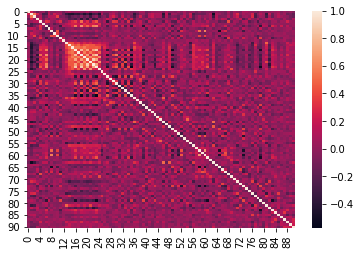

In [6]:
sns.heatmap(df.corr())

In [7]:
corr = [18,22,23]
for col in corr:
    dftrain.drop(col,axis=1,inplace=True)
    dftest.drop(col,axis=1,inplace=True)

In [8]:
y_train = dftrain[0].to_numpy().reshape(-1,1)
y_test  = dftest[0].to_numpy().reshape(-1,1)

dftrain.drop(0,axis=1,inplace=True)
dftest.drop(0,axis=1,inplace=True)

Ahora observamos las variables en función de su nivel de importancia.

In [9]:
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression

X_train = dftrain.to_numpy()
X_test  = dftest.to_numpy()

def dependencia(X,y,umbral):

    m = list(enumerate(mutual_info_regression(X, y, random_state=seed)))
    best = []

    for i, info in m:
        if info > umbral:
            best.append(i)
    return m, np.asarray(best)


m, v = dependencia(X_train, y_train.ravel(),0.1)

In [10]:
m

[(0, 0.044036260083196055),
 (1, 0.017563469717977398),
 (2, 0.01531788344706797),
 (3, 0.010138634513031874),
 (4, 0.005861900987746083),
 (5, 0.028540729096224737),
 (6, 0.012840255059256123),
 (7, 0.005782359163548634),
 (8, 0.006445115207750263),
 (9, 0.008928471549511485),
 (10, 0.007489248356206346),
 (11, 0.009372072576196544),
 (12, 0.006965061580700649),
 (13, 0.01438775523796565),
 (14, 0.007593506384816706),
 (15, 0.012259761251455004),
 (16, 0.0021114819613874403),
 (17, 0.007000156165696936),
 (18, 0.014844045647626203),
 (19, 0.00786804756025461),
 (20, 0.009094371677981883),
 (21, 0.010988124613483308),
 (22, 0.005063578777170008),
 (23, 0.00607326032245048),
 (24, 0.007903961734349707),
 (25, 0.00453622244075369),
 (26, 0.0036459163773496783),
 (27, 0.009169743450611278),
 (28, 0.004679079048862889),
 (29, 0.010456213508314605),
 (30, 0.002393940950724982),
 (31, 0.004434163615682607),
 (32, 0.014799395134046378),
 (33, 0.016167322967838516),
 (34, 0.006668628317749281)

Vemos que todas tienen mas o menos la misma importancia y decidimos no eliminar ninguna. A continuación vamos a pasar a reducir la dimensión de los datos usando PCA

# Reducción dimensión
Vamos a aplicar PCA. Notamos que esta técnica requiere de unos datos con los outliers tratados y normalizados ya que es sensible a estos dos fenómenos.

In [11]:
df,features = read_data()
dftrain, dftest = train_test_split(df.copy(), test_size = 0.2, train_size= 0.8, random_state=seed, shuffle=True)
dftrain_pre = dftrain.copy()
dftest_pre  = dftest.copy()
X_train, y_train, X_test, y_test = preprocesado(dftrain_pre,dftest_pre,corr=[18,23,22])

In [12]:
X_train_pca, X_test_pca,pca = dimensionality_reduction(n_components=55,X_train = X_train,X_test = X_test,show=True)

Varianza explicada:  0.9020381543128251
Componentes:  55


# Visualización

Visualizamos algunos atributos tras leerlos

In [13]:
df,features = read_data()
dftrain, dftest = train_test_split(df.copy(), test_size = 0.2, train_size= 0.8, random_state=seed, shuffle=True)
X_train, y_train = pandas_to_numpy(dftrain)
X_test, y_test = pandas_to_numpy(dftest)

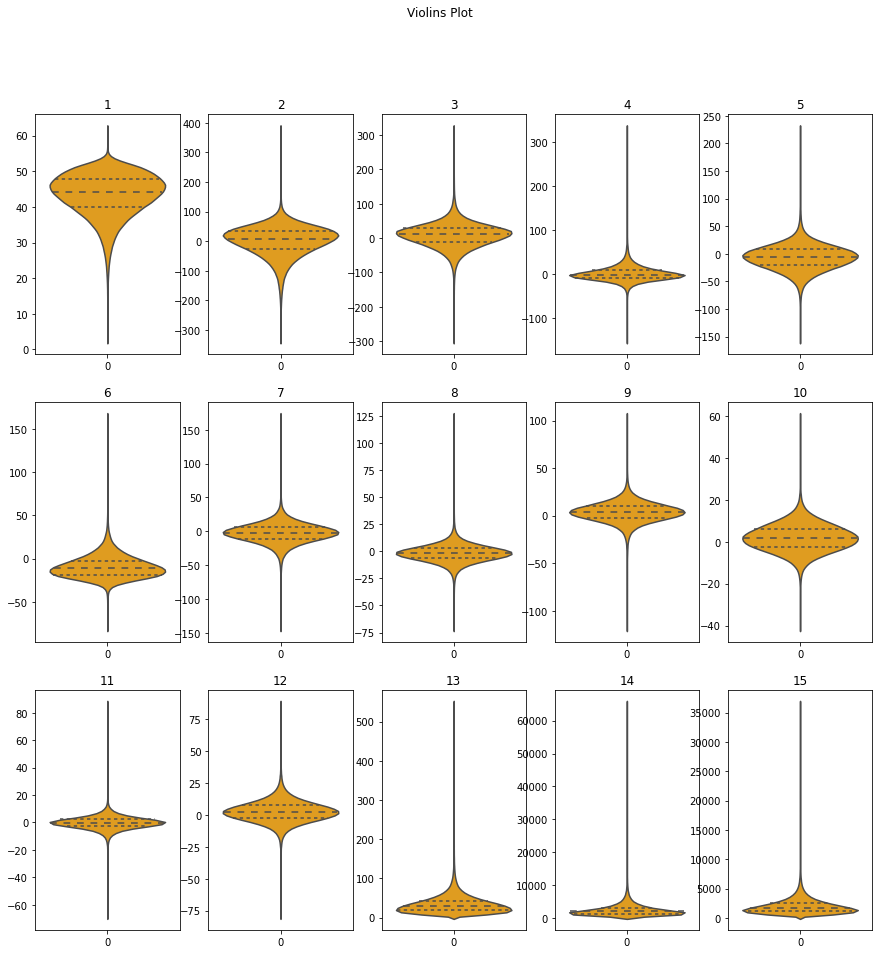

In [14]:
atributes = X_train.shape[1]
columns = 5
rows=3

fig, axes = plt.subplots(rows,columns,figsize=(15,15))
fig.suptitle('Violins Plot')

contador = 1

for i in range(rows):
    for j in range(columns):
        if contador < atributes:
            sns.violinplot(ax = axes[i][j], data = dftrain[contador],color='orange',inner='quartile')
            axes[i][j].set_title(str(contador))
            contador += 1
        
        

[Text(0.5, 1.0, 'Etiqueta')]

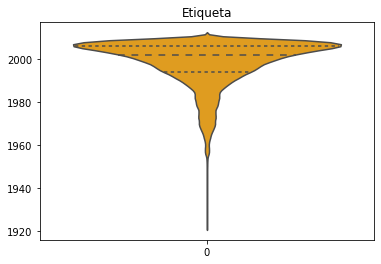

In [15]:
sns.violinplot(data = y_train,color='orange',inner='quartile').set(title='Etiqueta')

Vemos las dos y tres primeras componentes principales del conjunto de datos preprocesado

## PCA

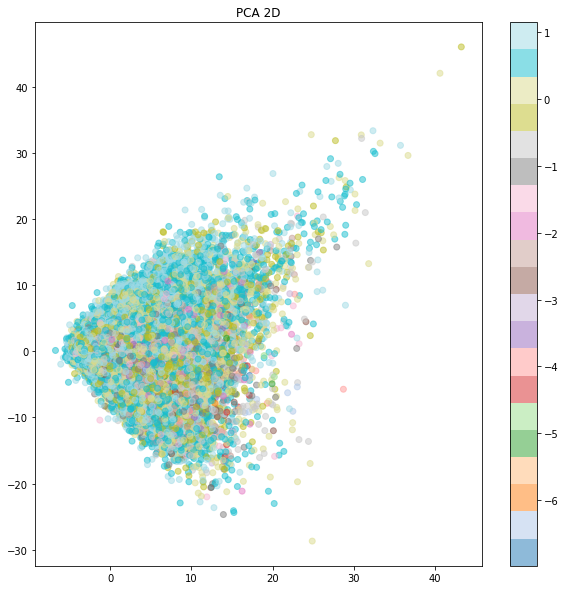

Varianza explicada en cada eje:  [0.09936898 0.07542097]
Varianza total:  0.17478995094070496


In [7]:
pca = PCA(n_components=2,random_state = seed)
visu_pca = pca.fit_transform(X_train)
plot2D(visu_pca,y_train,'PCA 2D')
print("Varianza explicada en cada eje: ", pca.explained_variance_ratio_)
print("Varianza total: ",pca.explained_variance_ratio_.sum())

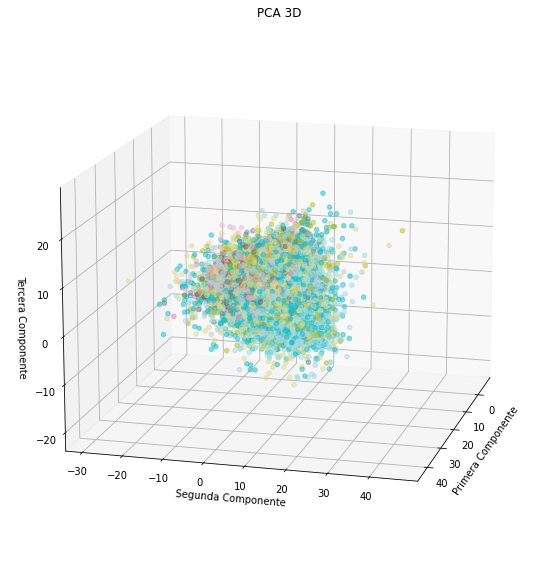

Varianza explicada en cada eje:  [0.09936898 0.07542097 0.06040759]
Varianza total:  0.23519754428765308


In [6]:
pca = PCA(n_components=3,random_state = seed)
visu_pca3 = pca.fit_transform(X_train)
plot3D(visu_pca3,y_train,'PCA 3D',view=[15,15])
print("Varianza explicada en cada eje: ", pca.explained_variance_ratio_)
print("Varianza total: ",pca.explained_variance_ratio_.sum())

## T-SNE

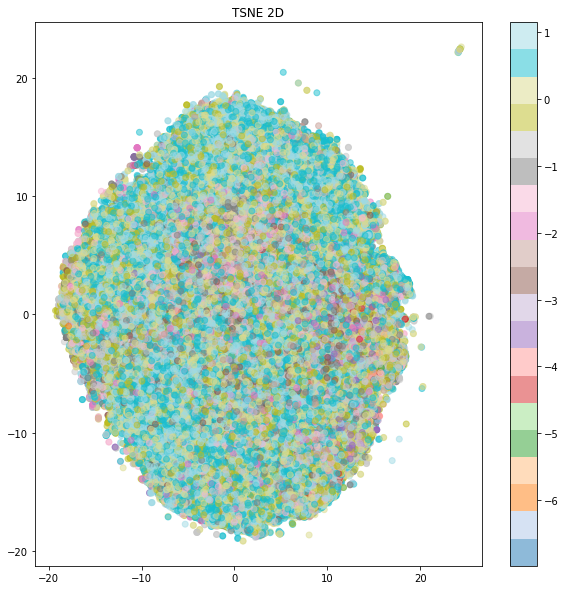

In [73]:
tsne = TSNE(n_components=2,init=visu_pca,random_state = seed)
visu_tsne = tsne.fit_transform(X_train)
plot2D(visu_tsne,y_train,'TSNE 2D')

## Desviaciones estándar

In [10]:
df_pca = pd.DataFrame(X_train_pca)

In [11]:
df_info = df_pca.describe()

In [12]:
df_info

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
count,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,...,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05,4.078060e+05
mean,-1.031474e-17,-3.902875e-18,1.233587e-17,-1.324190e-18,-1.547211e-17,-4.138093e-18,-1.681372e-18,1.254495e-18,7.526973e-18,-7.039113e-18,...,1.673532e-17,-1.097684e-17,-2.648379e-18,7.962561e-18,1.001854e-17,8.537538e-18,5.505841e-18,-3.136239e-18,-5.575535e-18,-1.663949e-18
std,2.940259e+00,2.561570e+00,2.292482e+00,1.949992e+00,1.826967e+00,1.550045e+00,1.460392e+00,1.426077e+00,1.362980e+00,1.328451e+00,...,7.589932e-01,7.483738e-01,7.411173e-01,7.338509e-01,7.247499e-01,7.123721e-01,7.054788e-01,6.927339e-01,6.757730e-01,6.693268e-01
min,-6.757830e+00,-2.867650e+01,-2.042551e+01,-1.398958e+01,-2.432497e+01,-1.610964e+01,-1.748518e+01,-2.116970e+01,-1.504959e+01,-1.827383e+01,...,-8.285713e+00,-1.043343e+01,-9.565686e+00,-8.315593e+00,-1.179828e+01,-8.810138e+00,-1.037150e+01,-9.569999e+00,-1.015321e+01,-7.204961e+00
25%,-2.068221e+00,-1.086979e+00,-1.021126e+00,-1.188908e+00,-9.101569e-01,-7.533339e-01,-7.204756e-01,-7.172359e-01,-7.774662e-01,-7.127581e-01,...,-3.804792e-01,-3.805586e-01,-3.768778e-01,-4.045463e-01,-3.646147e-01,-3.685390e-01,-3.617777e-01,-3.440199e-01,-3.481077e-01,-3.514668e-01
50%,-5.878836e-01,7.136223e-02,2.939804e-01,6.641454e-03,-6.287658e-02,2.093267e-03,4.835502e-02,6.674424e-03,-8.760460e-02,-2.504026e-02,...,-8.833620e-03,-1.511084e-02,-8.449170e-03,-2.620651e-02,7.209803e-03,5.241438e-03,-4.090685e-03,-5.517289e-03,3.308840e-03,9.130432e-03
75%,1.353501e+00,1.163466e+00,1.329004e+00,1.100208e+00,9.158328e-01,7.537008e-01,7.215039e-01,7.213193e-01,6.952093e-01,6.913321e-01,...,3.676037e-01,3.747717e-01,3.552558e-01,3.830018e-01,3.659326e-01,3.742137e-01,3.539612e-01,3.399613e-01,3.450834e-01,3.536405e-01
max,4.325605e+01,4.600198e+01,2.694792e+01,1.769245e+01,2.898165e+01,2.372831e+01,2.310603e+01,2.355973e+01,1.702431e+01,2.790028e+01,...,1.264164e+01,1.210790e+01,1.133664e+01,1.139817e+01,1.414425e+01,1.109845e+01,1.070815e+01,9.921665e+00,1.084746e+01,9.857875e+00


In [13]:
vstd = np.asarray(df_info.iloc[2])
print("Desviación típica máxima: ",vstd.max())
print("Desviación típica mínima: ",vstd.min())

Desviación típica máxima:  2.9402588569445056
Desviación típica mínima:  0.6693267963625048


In [15]:
atributes = df_pca.shape[1]
columns = 4
rows = int(np.ceil(atributes/columns))
columns=3
rows=3

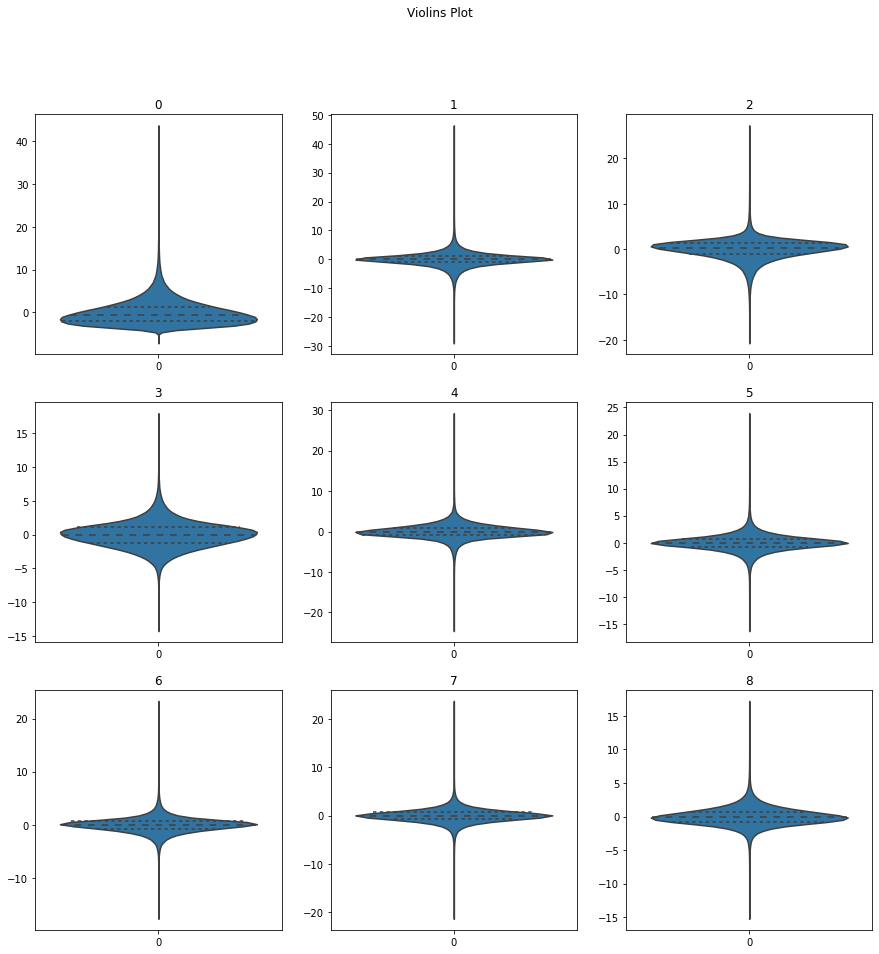

In [18]:
fig, axes = plt.subplots(rows,columns,figsize=(15,15))
fig.suptitle('Violins Plot')

contador = 0

for i in range(rows):
    for j in range(columns):
        if contador < atributes:
            sns.violinplot(ax = axes[i][j], data = df_pca[contador],inner='quartile')
            axes[i][j].set_title(str(contador))
            contador += 1
        
        

# Modelos
Datos:
- df
- dftrain, dftest
- dftrain_pre, dftest_pre -- X_train,y_train, X_test,y_test
- X_train_pca, X_test,pca

In [16]:
df,features = read_data()
dftrain, dftest = train_test_split(df.copy(), test_size = 0.2, train_size= 0.8, random_state=seed, shuffle=True)
dftrain_pre = dftrain.copy()
dftest_pre  = dftest.copy()
X_train, y_train, X_test, y_test = preprocesado(dftrain_pre,dftest_pre,corr=[18,23,22])

In [17]:
X_train_pca, X_test_pca,pca = dimensionality_reduction(n_components=55,X_train = X_train,X_test = X_test,show=True)

Varianza explicada:  0.9020381543128251
Componentes:  55


## Regresión Linear

In [18]:
# Parametros a tunear
param1 = {'alpha':np.logspace(-5,5,5),'epsilon':[0.1,0.01]}
# Regresión lineal usando SGD
reg1 = SGDRegressor(loss = 'squared_epsilon_insensitive', 
                    penalty = 'l1', 
                    max_iter = 1000, 
                    tol=0.0001, 
                    shuffle = True, 
                    verbose = 0,
                    random_state = seed, 
                    learning_rate = 'adaptive')

grid1 = apply_grid(reg1,param1,X_train_pca,y_train.ravel(),'-----SGDRegressor-----',True)
#rid1.to_csv('reg_sgd1')

-----SGDRegressor-----
Best Score:  0.86031407484403
Best Params:  {'alpha': 1e-05, 'epsilon': 0.01}


In [19]:
grid2 = apply_grid(reg1,param1,X_train,y_train.ravel(),'-----SGDRegressor-----',True)
#grid2.to_csv('reg_sgd2_sin_pca')

-----SGDRegressor-----
Best Score:  0.7632355035536845
Best Params:  {'alpha': 1e-05, 'epsilon': 0.01}


## SVR - Linear

In [20]:
param2 = {'C':np.logspace(-5,5,5), 'epsilon':[0,0.01,0.1]}
   
svr = LinearSVR(loss='squared_epsilon_insensitive',
                dual=False,
                tol=0.0001, 
                max_iter=10000, 
                random_state=seed)

grid_svr_pca = apply_grid(svr,param2,X_train_pca.copy(),y_train.ravel().copy(),'-----LinearSVR-----',True)
#grid_svr_pca.to_csv('grid_svr_pca.csv')

-----LinearSVR-----
Best Score:  0.8603113286662604
Best Params:  {'C': 0.0031622776601683794, 'epsilon': 0}


In [21]:
svr = LinearSVR(loss='squared_epsilon_insensitive',
                dual=False,
                tol=0.0001, 
                max_iter=10000, 
                random_state=seed)
grid_svr = apply_grid(svr,param2,X_train.copy(),y_train.ravel().copy(),'-----LinearSVR-----',True)
#grid_svr.to_csv('grid_svr.csv')

-----LinearSVR-----
Best Score:  0.7632133424271804
Best Params:  {'C': 0.0031622776601683794, 'epsilon': 0}


# Modelos Ganadores:
Entrenamos con Train y los evaluamos en Test.

In [22]:
# Declaramos los modelos ganadores
rl_pca = SGDRegressor(loss = 'squared_epsilon_insensitive', 
                    penalty = 'l1', 
                    max_iter = 1000, 
                    tol=0.0001, 
                    shuffle = True, 
                    verbose = 0,
                    random_state = seed, 
                    learning_rate = 'adaptive',
                    alpha = 1,
                    epsilon = 0.01)
rl = SGDRegressor(loss = 'squared_epsilon_insensitive', 
                    penalty = 'l1', 
                    max_iter = 1000, 
                    tol=0.0001, 
                    shuffle = True, 
                    verbose = 0,
                    random_state = seed, 
                    learning_rate = 'adaptive',
                    alpha = 1,
                    epsilon = 0.01)
svr_pca = LinearSVR(loss='squared_epsilon_insensitive',
                dual=False,
                tol=0.0001, 
                max_iter=10000, 
                random_state=seed,
                epsilon = 0.1,
                C = 0.00005)
svr  = LinearSVR(loss='squared_epsilon_insensitive',
                dual=False,
                tol=0.0001, 
                max_iter=10000, 
                random_state=seed,
                epsilon = 0.1,
                C = 0.00005)

In [23]:
modelos_pca = [rl_pca,svr_pca]
modelos = [rl,svr]

modelos_pca_str = ['rl_pca','svr_pca']
modelos_str = ['rl','svr']

In [24]:
for i,model in enumerate(modelos_pca):
    get_final_results(model,X_train_pca,y_train.ravel(),X_test_pca,y_test.ravel(),name_modelo=f'-----{modelos_pca_str[i]}-----',show=True)

for i,model in enumerate(modelos):
    get_final_results(model,X_train,y_train.ravel(),X_test,y_test.ravel(),name_modelo=f'-----{modelos_str[i]}-----',show=True)    

-----rl_pca-----
MSE en el conjunto de entranamiento:  1.0000061912088893
MSE en el conjunto de test:  0.9951774028092436
-----svr_pca-----
MSE en el conjunto de entranamiento:  0.860737466215284
MSE en el conjunto de test:  0.8586935775140611
-----rl-----
MSE en el conjunto de entranamiento:  1.0000061912088893
MSE en el conjunto de test:  0.9951774028092436
-----svr-----
MSE en el conjunto de entranamiento:  0.76505419524659
MSE en el conjunto de test:  0.763229701660486


# Curvas de aprendizaje

In [25]:
winner = LinearSVR(loss='squared_epsilon_insensitive',
                dual=False,
                tol=0.0001, 
                max_iter=10000, 
                random_state=seed,
                epsilon = 0.1,
                C = 0.00005)

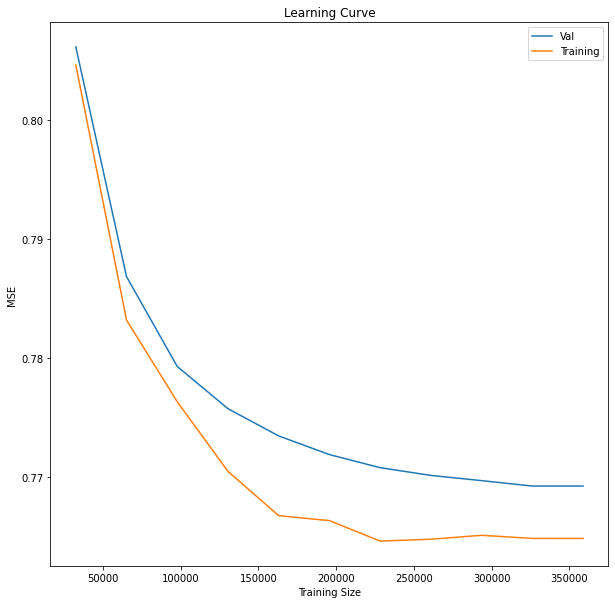

In [26]:
plot_learning_curve(X_train,y_train.ravel(),percentage=0.1,modelo = winner,metrica=mean_squared_error,modelo_str = 'SGDR-PCA',metrica_str = 'MSE',stratify = False, figsize = (10,10))

# Entrenamos con todos los datos

In [27]:
df,features = read_data()
X_train, y_train = preprocesado(df,corr=[18,23,22], training_only = True)

In [28]:
from sklearn.model_selection import cross_val_score
winner = LinearSVR(loss='squared_epsilon_insensitive',
                dual=False,
                tol=0.0001, 
                max_iter=10000, 
                random_state=seed,
                epsilon = 0.1,
                C = 0.00005)
# Barajamos el conjunto de datos
X_train, y_train = shuffle(X_train,y_train,random_state=seed)
# Aplicamos Cross Validation
E_val = cross_val_score(winner, X_train, y=y_train,scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=0)

In [29]:
E_val.mean()

-0.7652744256766255

In [30]:
winner = LinearSVR(loss='squared_epsilon_insensitive',
                dual=False,
                tol=0.0001, 
                max_iter=10000, 
                random_state=seed,
                epsilon = 0.1,
                C = 0.00005)

In [31]:
winner.fit(X_train,y_train.ravel())
ypred = winner.predict(X_train)
mean_squared_error(y_train,ypred)

0.7645394138650042